In [9]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Custom modules and functions
import capstone.portfolio.optimize as opt
from capstone.model_selection import overunder_error, ts_cross_val_score_fwd
from capstone.portfolio.metrics import Metrics
from capstone.portfolio.backtest import backtest_portfolios
from capstone.portfolio.prune import prune_allocations
from capstone.utils import read_file, get_sectors

# Machine learning and modeling tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

# Progress bar for loops
from tqdm.auto import tqdm

# Set visualization style and adjust plot settings
sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = .75
plt.rcParams["axes.edgecolor"] = "k"

In [3]:
# Load files
# We'll need three files for the analysis
df = read_file("master_df", index_col="Date")
snp_log_returns = read_file("snp_log_returns", index_col="Date")
stocks_by_sector = read_file("stocks_by_sector", index_col=0)
sectors = get_sectors()

df.shape

(4230, 120)

In [4]:
# Separate the combined dataframe into targets (sector average returns) and features
targets = df[sectors]
features = df[df.columns[~df.columns.isin(sectors)]]

features.shape, targets.shape

((4230, 109), (4230, 11))

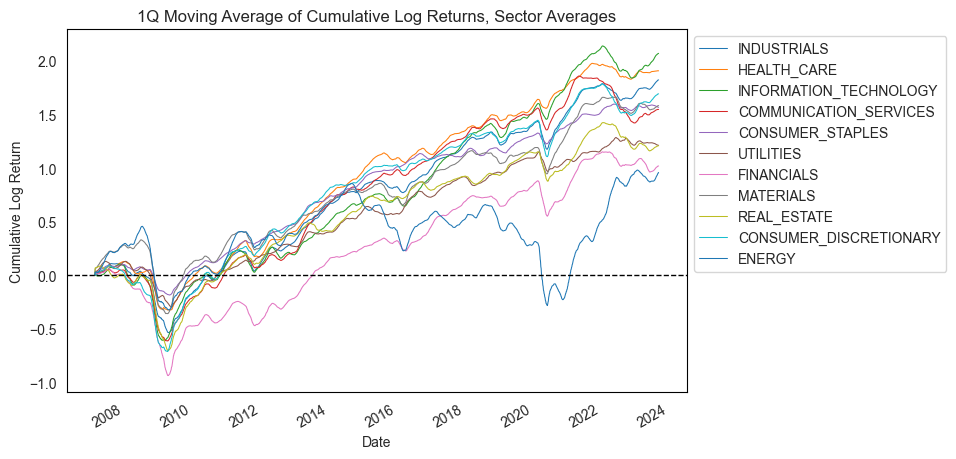

In [5]:
# Plot rolling n average of sector average cumulative return
n=63
sector_cum_ret_ma = targets.cumsum().rolling(n).mean()
sector_cum_ret_ma.loc[sector_cum_ret_ma.first_valid_index()] = 0
sector_cum_ret_ma.plot(figsize=(8, (8*(2/3))), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title(f"{n//63}Q Moving Average of Cumulative Log Returns, Sector Averages")
plt.ylabel("Cumulative Log Return")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

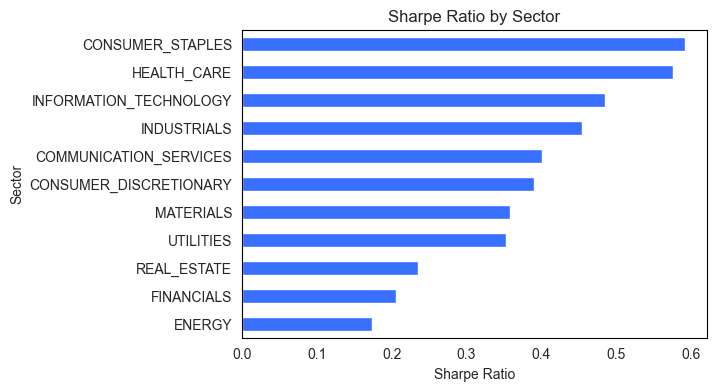

In [6]:
# Compute metrics for sector averages and plot Sharpe ratios
metrics = Metrics()
metric = "Sharpe Ratio"
sector_metrics = metrics.calculate(targets).sort_values(by=metric)

sector_metrics[metric].plot.barh(
    figsize=(6, (6*(2/3))),
    grid=False,
    color="#396FFF",
)

plt.title(f"{metric} by Sector")
plt.ylabel("Sector")
plt.xlabel("Sharpe Ratio")
plt.show()

In [8]:
# Intitialize PCA, explaining >= 80% of the variance
pca = PCA(n_components=.8, random_state=42)

# Initialize a standard scaler
scaler = StandardScaler()

# Create a dictionary of regression models designed for working with stock returns
models = {
    # ElasticNet combines L1 and L2 regularization, suitable for feature selection and dealing with multicollinearity.
    'ElasticNet': make_pipeline(scaler, pca, ElasticNet(alpha=1, l1_ratio=0.5, random_state=42)),
    
    # Support Vector Regressor (SVR) with an RBF kernel can capture non-linear relationships in stock returns.
    'SVR': make_pipeline(scaler, pca, SVR(kernel='rbf', C=1, gamma='auto')),
    
    # RandomForestRegressor is an ensemble method that can capture complex relationships and feature importance.
    'RandomForest': make_pipeline(scaler, pca, RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)),
    
    # GradientBoostingRegressor is another ensemble method suitable for capturing non-linear relationships and trends.
    'GradientBoost': make_pipeline(scaler, pca, GradientBoostingRegressor(n_estimators=100, random_state=42)),
    
    # XGBoostRegressor is an optimized gradient boosting algorithm known for its speed and performance.
    'XGBoost': make_pipeline(scaler, pca, XGBRegressor(n_estimators=100, random_state=42)),
}

# Explanation for parameter choices:

# ElasticNet Parameters:
#   - alpha=1: Strong regularization to prevent overfitting.
#   - l1_ratio=0.5: Balanced mix of L1 (Lasso) and L2 (Ridge) regularization.
#   - random_state=42: Ensures reproducible results.

# SVR Parameters:
#   - kernel='rbf': RBF kernel to capture non-linear stock return relationships.
#   - C=1: Moderate regularization to control model complexity.
#   - gamma='auto': Automatic kernel coefficient selection based on data.

# RandomForestRegressor Parameters:
#   - n_estimators=100: 100 decision trees balance complexity and predictive power.
#   - max_depth=3: Shallow trees to prevent overfitting.
#   - random_state=42: Ensures reproducible ensemble results.

# GradientBoostingRegressor Parameters:
#   - n_estimators=100: 100 boosting stages capture complex relationships.
#   - random_state=42: Ensures reproducible ensemble results.

# XGBoostRegressor Parameters:
#   - n_estimators=100: 100 boosting rounds balance performance and efficiency.
#   - random_state=42: Ensures reproducible results with XGBoost.

In [8]:
# Set the forecast horizon to 126 days (approx. 1/2 trading year)
forecast = 126

# Shift the features to match the forecast horizon and remove NA rows
X_shifted = features.shift(forecast).dropna()

# Reindex the target data to align with the shifted features
y_all = df[sectors].reindex(X_shifted.index)

# Initialize empty DataFrames to store model predictions and Over-Under loss (OUL)
preds = {model: pd.DataFrame() for model in models.keys()}
ouls = {model: pd.DataFrame() for model in models.keys()}

# Loop through each sector in the target data
for sector in tqdm(y_all.columns):
    
    # Loop through each machine learning model
    for name, model in models.items():

        # Copy the target data for the current sector
        y = y_all[sector]

        # Loop through the data in steps of 'forecast' days
        for i in range(forecast, len(y), forecast):
            
            # Split the data into rolling windows for training and testing
            X_train = X_shifted.iloc[i-forecast:i]
            X_test = X_shifted.iloc[i:i+forecast]
            y_train = y.iloc[i-forecast:i]
            y_test = y.iloc[i:i+forecast]

            # Split the rolling training window into train and validation sets
            mean_oul = np.mean(
                ts_cross_val_score_fwd(
                    model, 
                    X_train, 
                    y_train, 
                    cv=2, 
                    scorer=overunder_error, 
                    underpred_penalty=0,
                    overpred_penalty=2
                )
            )
            
            # Take the mean of the OULs
            ouls[name].loc[X_test.index.min(), sector] = mean_oul

            # Fit the model on the full rolling training window and predict on the test set
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            # Store the mean of the predicted values (predicted logarithmic returns)
            preds[name].loc[X_test.index.min(), sector] = np.mean(y_hat)

        # Convert the stored predictions and ouls to float type
        preds[name][sector] = preds[name][sector].astype(float)
        ouls[name][sector] = ouls[name][sector].astype(float)

  0%|          | 0/11 [00:00<?, ?it/s]

In [9]:
# Determine the sector with the maximum value across time
model_preds = {model: pd.Series(pred.idxmax(axis=1), name=model) for model, pred in preds.items()}

# Concatenate the Series from each model into a single DataFrame
model_preds = pd.concat([pred for pred in model_preds.values()], axis=1)

# Display the first few rows of the model_preds DataFrame
model_preds.head()

,ElasticNet,SVR,RandomForest,GradientBoost,XGBoost
2007-11-20,ENERGY,INDUSTRIALS,ENERGY,INFORMATION_TECHNOLOGY,UTILITIES
2008-05-22,ENERGY,CONSUMER_DISCRETIONARY,ENERGY,UTILITIES,COMMUNICATION_SERVICES
2008-11-19,CONSUMER_STAPLES,UTILITIES,REAL_ESTATE,REAL_ESTATE,REAL_ESTATE
2009-05-22,CONSUMER_DISCRETIONARY,UTILITIES,REAL_ESTATE,REAL_ESTATE,CONSUMER_DISCRETIONARY
2009-11-19,REAL_ESTATE,INDUSTRIALS,INFORMATION_TECHNOLOGY,COMMUNICATION_SERVICES,COMMUNICATION_SERVICES


In [10]:
# Calculate the mean of each DataFrame in the 'ouls' dictionary along the rows
mean_ouls = {model: pd.Series(oul.mean(axis=1), name=model) for model, oul in ouls.items()}

# Concatenate the mean Series from each model into a single DataFrame
mean_ouls = pd.concat([oul for oul in mean_ouls.values()], axis=1)

# Find the model with the minimum mean value for each row (axis=1)
best_models = mean_ouls.idxmin(axis=1)

# Display the first few rows of the best_models Series
best_models.head()

2007-11-20    RandomForest
2008-05-22             SVR
2008-11-19    RandomForest
2009-05-22         XGBoost
2009-11-19      ElasticNet
dtype: object

In [11]:
# Create an empty DataFrame
results = pd.DataFrame(
    columns=["SELECTED_MODEL", "SELECTED_SECTOR", "AVAILABLE_STOCKS"],
    index=best_models.index
)

# Loop through dates in the best_models index
for date in best_models.index:

    # Get the best model for the current date
    best_model = best_models.loc[date]

    # Predict the selected sector using the best model
    selected_sector = model_preds.loc[date, best_model]

    # Store the selected model and sector in the results DataFrame
    results.loc[date, "SELECTED_MODEL"] = best_model
    results.loc[date, "SELECTED_SECTOR"] = selected_sector

    # Retrieve the selected sector's constituents from stocks_by_sector DataFrame
    sector_constituents = stocks_by_sector[stocks_by_sector["GICS Sector"] == selected_sector]["Symbol"]

    # Filter out constituents that are not in snp_log_returns columns
    sector_constituents = [c for c in sector_constituents if c in snp_log_returns.columns]

    # Store the available stocks as a space-separated string
    results.loc[date, "AVAILABLE_STOCKS"] = ' '.join(sector_constituents)

# Split the space-separated stock symbols into an array
results["AVAILABLE_STOCKS"] = results["AVAILABLE_STOCKS"].apply(lambda s: np.array(s.split()))

In [12]:
# Get unique available stocks from the results DataFrame
available_stocks = results.explode("AVAILABLE_STOCKS")['AVAILABLE_STOCKS'].unique()

# Create DataFrames to store allocations for different strategies
ms_allocations = pd.DataFrame(columns=available_stocks, index=results.index)
mv_allocations = pd.DataFrame(columns=available_stocks, index=results.index)
rp_allocations = pd.DataFrame(columns=available_stocks, index=results.index)

# Initialize columns for Sharpe ratios in the results DataFrame
results[["EW_SHARPE", "MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = np.nan

# Loop through dates in the results index
for date in tqdm(results.index):

    # Get selected stocks for the current date
    selected_stocks = results.loc[date, "AVAILABLE_STOCKS"]

    # Retrieve past returns for selected stocks within the forecast window
    past_returns = snp_log_returns[selected_stocks].loc[:date][-forecast:]

    # Initialize equal-weighted portfolio weights
    weights = np.array([1/len(selected_stocks)] * len(selected_stocks))

    # Calculate and store the Equal-Weighted (EW) Sharpe ratio
    results.at[date, "EW_SHARPE"] = opt.port_sharpe(weights, past_returns)

    # Calculate the Maximum Sharpe (MS) and Minimum Variance (MV) portfolios
    ms_w, ms_s = opt.max_sharpe_opt(weights, past_returns)
    mv_w, mv_s = opt.min_var_opt(weights, past_returns)

    # Calculate and store the Risk Parity (RP) portfolio
    rp_w, rp_s = opt.risk_parity_opt(weights, past_returns)

    # Store allocations for each strategy
    ms_allocations.loc[date, selected_stocks] = ms_w
    mv_allocations.loc[date, selected_stocks] = mv_w
    rp_allocations.loc[date, selected_stocks] = rp_w

    # Store Sharpe ratios for MS, MV, and RP strategies
    results.loc[date, ["MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = [ms_s, mv_s, rp_s]

# Drop the "AVAILABLE_STOCKS" column from the results DataFrame and display the first few rows
results.drop("AVAILABLE_STOCKS", axis=1).head()

  0%|          | 0/32 [00:00<?, ?it/s]

,SELECTED_MODEL,SELECTED_SECTOR,EW_SHARPE,MS_SHARPE,MV_SHARPE,RP_SHARPE
2007-11-20,RandomForest,ENERGY,0.486888,1.778393,-0.130395,0.425154
2008-05-22,SVR,CONSUMER_DISCRETIONARY,-0.371399,1.631071,-0.329665,-0.415744
2008-11-19,RandomForest,REAL_ESTATE,-2.243185,-0.907286,-1.767807,-2.268467
2009-05-22,XGBoost,CONSUMER_DISCRETIONARY,1.472726,3.512499,1.330893,1.620865
2009-11-19,ElasticNet,REAL_ESTATE,1.792080,3.182959,1.885873,1.902636


In [13]:
# Prune the allocation DataFrames (ms_allocations, mv_allocations, rp_allocations)
# by removing weights below a minimum weight threshold of 0.01 and re-normalizing the remaining weights.
ms_allocations, mv_allocations, rp_allocations = prune_allocations(
    ms_allocations, mv_allocations, rp_allocations, min_weight_th=0.01 
)

In [14]:
# Select constituent returns based on columns in ms_allocations
constituent_returns = snp_log_returns[ms_allocations.columns]

# Backtest portfolios for MS, MV, and RP strategies using the specified allocations
ms_port_rets, mv_port_rets, rp_port_rets = backtest_portfolios(
    ms_allocations, 
    mv_allocations, 
    rp_allocations, 
    constituent_returns=constituent_returns
)

# Calculate the equal-weighted portfolio returns by taking the mean of constituent returns
ew_port_rets = constituent_returns.sum(axis=1) / len(constituent_returns.columns)

# Reindex the equal-weighted portfolio returns to match the other portfolio returns' index
ew_port_rets = ew_port_rets.reindex(ms_port_rets.index)

# Set the return at the earliest date to 0 for consistency
ew_port_rets.loc[ew_port_rets.index.min()] = 0

In [15]:
# Concatenate the portfolio returns (ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets) horizontally
port_rets = pd.concat([ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets], axis=1)

# Rename the columns to describe each portfolio strategy
port_rets.columns = ["ONE_OVER_N", "MAX_SHARPE", "MIN_VAR", "RISK_PARITY"]

# Create an instance of the Metrics class
portfolio_metrics = Metrics()

# Calculate portfolio metrics (e.g., mean return, volatility, Sharpe ratio) using the Metrics class
portfolio_metrics.calculate(port_rets)

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.601788,3.146709,0.199339,0.331245
RISK_PARITY,0.444616,2.048778,0.129787,0.291908
MIN_VAR,0.483744,1.771146,0.112199,0.231939
ONE_OVER_N,0.416223,1.504212,0.095289,0.228938


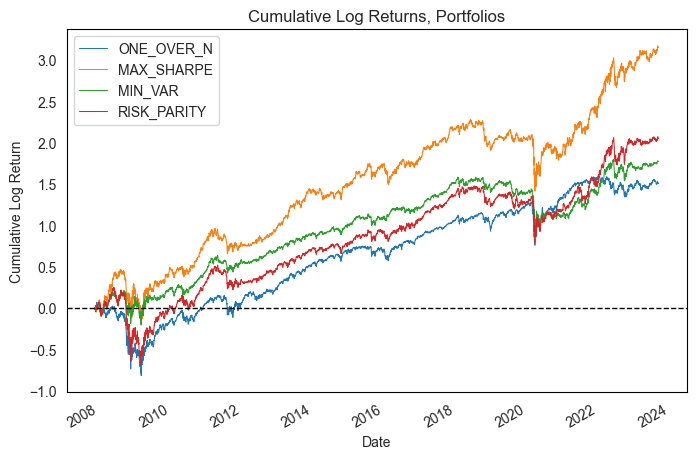

In [47]:
# Plot cumulative returns of each portfolio
port_rets.cumsum().plot(figsize=(8, (8*(2/3))), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns, Portfolios")
plt.ylabel("Cumulative Log Return")
plt.show()

In [31]:
# Compare the best portfolio with sector returns
sector_metrics = Metrics()

best_portfolio = portfolio_metrics.metrics['Cumulative Return'].idxmax()
sector_returns_reindexed = df[sectors].reindex(port_rets.index).copy()
sector_returns_reindexed.loc[sector_returns_reindexed.index.min()] = 0
sector_comparison = pd.concat([port_rets[best_portfolio], sector_returns_reindexed], axis=1)
sector_metrics.calculate(sector_comparison)[:5]

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.601788,3.146709,0.199339,0.331245
INFORMATION_TECHNOLOGY,0.499812,2.039880,0.129223,0.258544
HEALTH_CARE,0.567355,1.766901,0.111930,0.197285
INDUSTRIALS,0.464853,1.755934,0.111236,0.239292
CONSUMER_DISCRETIONARY,0.415844,1.695079,0.107381,0.258224


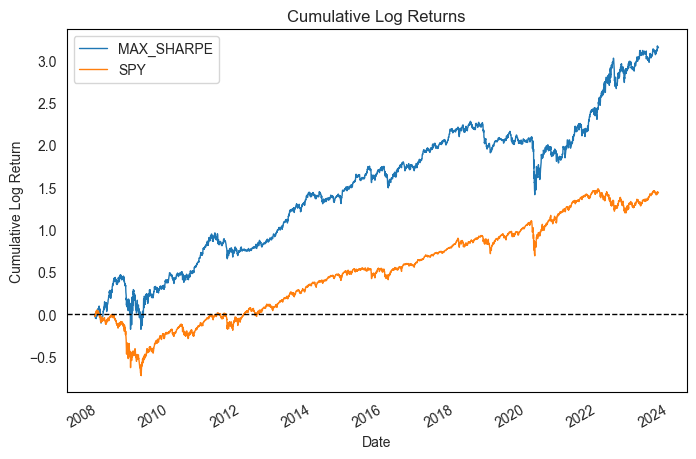

In [41]:
# Compare best portfolio to S&P 500
SPY_metrics = Metrics()

# Load SPY prices
SPY_log_rets = read_file("spy_log_returns", "data", index_col="Date")
SPY_log_rets.columns = ["SPY"]

# Combine SPY returns and best portfolo returns into a dataframe for comparison
spy_comparison = pd.concat([port_rets[best_portfolio], SPY_log_rets], axis=1)
spy_comparison.cumsum().plot(figsize=(8, (8*(2/3))), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns")
plt.ylabel("Cumulative Log Return")
plt.show()

In [42]:
# Inspect portfolio metrics against SPY
SPY_metrics.calculate(spy_comparison)

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.601788,3.146709,0.199339,0.331245
SPY,0.444477,1.438849,0.091149,0.205070
